# 1. Deep Learning with PyTorch - A 60 Minute Blitz 
## 4. Training a Classifier

URL : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Contents
1. What about data?
2. Training an image classifier
3. Training on GPU
4. Training on multiple GPUs
5. Where do i go next?

# 1. What about data?

# 2. Training an image classifier

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

## 2-1. Load and normalizing the CIFAR10 training and test datasets using torchvision

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.5,.5,.5), (.5,.5,.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


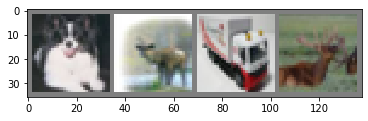

  dog  deer truck  deer


In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
images.shape

torch.Size([4, 3, 32, 32])

## 2-2. Define a Convolutional Neural Network

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)#input channel, out_channel, kernel_size
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()        

## 2-3. Define a loss function

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 2-4. Train the network on the training data

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
for epoch in range(2):
    
    running_loss = 0.
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data        
        #inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        #outputs = net.to(device)(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i% 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %(epoch+1, i+1, running_loss / 2000))
            running_loss = 0.
            
print('Finished Training')

[1,  2000] loss: 2.211
[1,  4000] loss: 1.867
[1,  6000] loss: 1.687
[1,  8000] loss: 1.581
[1, 10000] loss: 1.517
[1, 12000] loss: 1.469
[2,  2000] loss: 1.414
[2,  4000] loss: 1.379
[2,  6000] loss: 1.315
[2,  8000] loss: 1.310
[2, 10000] loss: 1.276
[2, 12000] loss: 1.257
Finished Training


## 2-5. Test the network on the test data

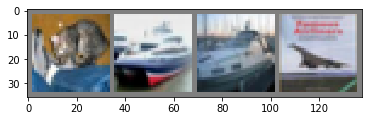

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car plane


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [13]:
print(labels, labels.size(0), (predicted == labels).sum().item())

tensor([3, 5, 1, 7]) 4 3


In [14]:
(predicted == labels).squeeze()

tensor([ True,  True, False,  True])

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))            

Accuracy of plane : 70 %
Accuracy of   car : 86 %
Accuracy of  bird : 37 %
Accuracy of   cat : 35 %
Accuracy of  deer : 47 %
Accuracy of   dog : 55 %
Accuracy of  frog : 70 %
Accuracy of horse : 61 %
Accuracy of  ship : 49 %
Accuracy of truck : 38 %


# 3. Training on GPU

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
inputs, labels = data[0].to(device), data[1].to(device)

# 4. Training on multiple GPUs

# 5. Where do i go next?